## Optimizing Triangle Loss
So far, we (and OAT) have focused on edge loss optimization. Here, we try to do triangle loss optimization on a cycle rep.

### Preliminaries

In [1]:
# load some packages
import Gavin.utils.make_network as mn
import Gavin.utils.optimizers as op
import matplotlib.pyplot as plt
from scipy import sparse
import gurobipy as gb
from time import time
import pandas as pd
import oatpy as oat
import numpy as np

# config
DATA_PATH = 'datasets/concept_network/'
# CONCEPT_FILE = 'articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz' # Applied Mathematics
# CONCEPT_FILE = 'concepts_Applied Economics_1402.csv.gz' # Applied Econ
CONCEPT_FILE = 'concepts_Zoology_608.csv' # Zoology
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MIN_FREQ = 0.0006
MAX_FREQ = 0.005

### Setup
Create the graph and solve for the network's homology. This, especially the `factored` object, will be used a lot in the optimization problem.

In [2]:
## Setup the graph
G = mn.gen_concept_network(
        DATA_PATH+CONCEPT_FILE,
        min_relevance=MIN_RELEVANCE,
        min_year=MIN_YEAR,
        min_articles=MIN_FREQ, # 0.006%
        max_articles=MAX_FREQ, # 0.05%
        normalize_year=True
    ) # use a filtered data file
adj = mn.adj_matrix(
        G,
        'norm_year',
        True,
        None
    )

In [3]:
## Solve homology
start = time()
# setup the problem
factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
        dissimilarity_matrix=adj,
        homology_dimension_max=2
    )
# solve homology
homology = factored.homology( # solve homology
        return_cycle_representatives=True, # These need to be true to be able to make a barcode, makes the problem take ~30% longer (1:30ish)
        return_bounding_chains=True
    )
f'Homology calculation took {time() - start} secs'

'Homology calculation took 0.5765891075134277 secs'

In [4]:
homology[(homology['dimension'] == 1)
         & (homology['death'] < np.inf)]

,dimension,birth,death,birth simplex,death simplex,cycle representative,cycle nnz,bounding chain,bounding nnz
id,,,,,,,,,
240,1,0.990099,1.000000,"[66, 217]","[66, 89, 217]",simplex filtration coefficient 0 [6...,17,simplex filtration coefficient 0 ...,86.0
254,1,0.980198,0.990099,"[160, 242]","[160, 242, 282]","simplex filtration coefficient 0 [160,...",6,simplex filtration coefficient 0 ...,8.0
256,1,0.980198,0.990099,"[111, 205]","[111, 181, 240]",simplex filtration coefficient 0 [11...,12,simplex filtration coefficient 0 ...,77.0
258,1,0.980198,1.000000,"[87, 276]","[87, 276, 282]","simplex filtration coefficient 0 [87,...",9,simplex filtration coefficient 0...,145.0
260,1,0.980198,0.990099,"[61, 200]","[61, 115, 200]",simplex filtration coefficient 0 [6...,19,simplex filtration coefficient 0 ...,73.0
...,...,...,...,...,...,...,...,...,...
671,1,0.722772,0.762376,"[5, 183]","[86, 170, 183]","simplex filtration coefficient 0 [5,...",6,simplex filtration coefficient 0 [...,4.0
672,1,0.693069,0.980198,"[43, 184]","[55, 266, 287]","simplex filtration coefficient 0 [43,...",5,simplex filtration coefficient 0 ...,15.0
673,1,0.693069,0.782178,"[43, 170]","[86, 170, 225]","simplex filtration coefficient 0 [43,...",6,simplex filtration coefficient 0 [...,6.0


### Edge Loss
Using edge loss, find a cycle rep and bounding chain for comparison.

In [5]:
# cycle we optimize
cycle_i = 530
death = homology.loc[cycle_i, 'death']
birth_simplex = homology.loc[cycle_i, 'birth simplex']

homology.loc[cycle_i:cycle_i]

,dimension,birth,death,birth simplex,death simplex,cycle representative,cycle nnz,bounding chain,bounding nnz
id,,,,,,,,,
530,1,0.861386,0.90099,"[36, 39]","[39, 95, 245]",simplex filtration coefficient 0 [...,14,simplex filtration coefficient 0 ...,48.0


In [6]:
# edge loss cycle
optimal_cycle = op.CycleOptimizer.optimize_a_cycle(
        birth_simplex,
        factored
    )
optimal_cycle

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2531206
Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 767 rows, 2044 columns and 4618 nonzeros
Model fingerprint: 0x3a0b615e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 481 rows and 589 columns
Presolve time: 0.01s
Presolved: 286 rows, 1455 columns, 4820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     125    3.1386139e+00   0.000000e+00  

,simplex,filtration,coefficient
0,"[86, 229]",0.683168,-1.0
1,"[39, 229]",0.742574,1.0
2,"[86, 245]",0.851485,1.0
3,"[39, 245]",0.861386,-1.0


In [7]:
# bounding chain
optimal_bounding_chain = op.BoundingChainOptimizer.optimize_a_bounding_chain(
        optimal_cycle,
        factored,
        death=death
    )
optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 1268 rows, 3628 columns and 10884 nonzeros
Model fingerprint: 0xd843787f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 779 rows and 740 columns
Presolve time: 0.01s
Presolved: 489 rows, 2888 columns, 7218 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9108911e-01   5.000000e+00   0.000000e+00      0s
Extra simplex iterations after uncrush: 18
      26    3.5841584e+00   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.584158416e+00


,simplex,filtration,coefficient
0,"[86, 95, 229]",0.891089,1.0
1,"[86, 95, 245]",0.891089,-1.0
2,"[39, 95, 229]",0.900990,-1.0
3,"[39, 95, 245]",0.900990,1.0


#### Triangle Loss

#### The LP
To optimize triangle loss, we'll simultaneously optimize the cycle rep and bounding chain. Essentially, we look for the cycle that obeys the cycle constraints and has the smallest bounding chain.

#### Setup
To find this, we'll need to know the birth and death times for the cycle as well as have an initial cycle rep.

In [8]:
# cycle info
birth = homology.loc[cycle_i, 'birth']
death = homology.loc[cycle_i, 'death']
cycle_dim = homology.loc[cycle_i, 'dimension']
inital_cycle_rep = homology.loc[cycle_i, 'cycle representative']
inital_cycle_rep['coefficient'] = inital_cycle_rep['coefficient'].astype(float)

# well use many times
simplex_indicies = factored.indices_boundary_matrix()

#### Boundary Matrix
The LP will use two boundary matrices: one filtered before death time to use to make the bounding chain and one filtered before birth time to make the cycle rep. We make the bigger one here, then slice it to make the smaller one in the LP.

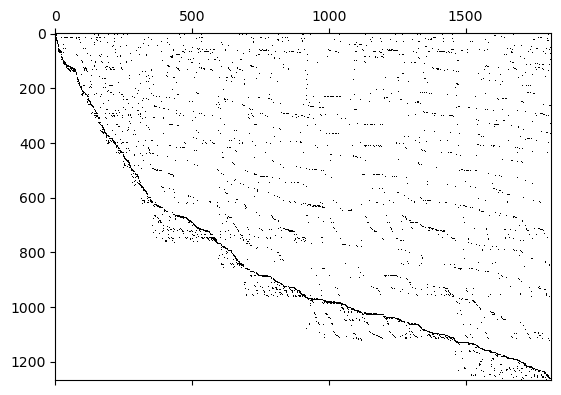

In [9]:
# get the boundry matrix
boundry_matrix = factored.boundary_matrix().astype(float)

# indicies
row_indicies = simplex_indicies[(simplex_indicies['simplex'].str.len() == cycle_dim+1) # simplicies in cycle
                                & (simplex_indicies['filtration'] <= death)].index
col_indicies = simplex_indicies[(simplex_indicies['simplex'].str.len() == cycle_dim+2) # simplicies in bounding chain
                                & (simplex_indicies['filtration'] <= death)].index

# make the boundry matrix
boundry_matrix = boundry_matrix[row_indicies, :][:, col_indicies]

plt.spy(boundry_matrix, marker=',', c='k')

#### Cycle Rep
The cycle rep is pre-filled in with the coefficients we know and includes only simplicies before the birth time. This is because everything after that is necessarily 0, so we don't need to optimize it

In [10]:
# get relevant simplicies
cycle_rep = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+1].reset_index(drop=True) # add 1 bc k dimensional simplicices have k+1 points
cycle_rep = cycle_rep[cycle_rep['filtration'] <= birth] # only need ones that exist before the death time

# figure out coefficients
cycle_rep = cycle_rep.assign(
        simplex=cycle_rep['simplex'].apply(tuple) # can't merge on lists, convert to tuples first (which is hashable)
    ).merge(
        right=inital_cycle_rep.assign(
                simplex=inital_cycle_rep['simplex'].apply(tuple) # same list merge issue
            ),
        on=['simplex', 'filtration'],
        how='left' # keep cycle rep list as is, just with coefificeint column
    ).assign(
        simplex=cycle_rep['simplex'].apply(list) # convert back to list (prolly doesn't need to done done but still)
    ).replace(
        np.nan, 0 # set unmerged columns to 0
    )

cycle_rep

,simplex,filtration,coefficient
0,"[16, 24]",0.039604,0.0
1,"[22, 33]",0.069307,0.0
2,"[7, 33]",0.079208,0.0
3,"[86, 225]",0.099010,1.0
4,"[86, 234]",0.099010,-1.0
...,...,...,...
762,"[261, 285]",0.861386,0.0
763,"[261, 287]",0.861386,0.0
764,"[261, 289]",0.861386,0.0
765,"[282, 293]",0.861386,0.0


#### Bounding Chain
The bounding chain includes all simplicies before the death of the cycle. It has no coefficients (yet), since those are solved for in the optimization problem

In [11]:
# bounding chain
# get relevant simplicies
bounding_chain = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+2].reset_index(drop=True) # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
bounding_chain = bounding_chain[bounding_chain['filtration'] <= death] # only need ones that exist before the death time

bounding_chain

,simplex,filtration
0,"[86, 225, 234]",0.099010
1,"[7, 16, 24]",0.108911
2,"[7, 22, 33]",0.178218
3,"[170, 226, 229]",0.485149
4,"[161, 225, 233]",0.514851
...,...,...
1809,"[246, 257, 260]",0.900990
1810,"[249, 260, 274]",0.900990
1811,"[257, 259, 260]",0.900990
1812,"[257, 260, 294]",0.900990


#### Cycle Basis
This is added to the boundary matrix to create a basis for all the cycles in the LP.

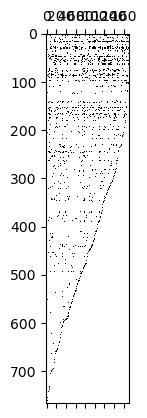

In [12]:
# cycles in the cycle basis
cycle_basis_cycles = homology[(homology['dimension'] == cycle_dim) # should have the same dimension as the cycle
                              & (homology['birth'] <= birth) # should be born before the cycle
                              & (homology.index != cycle_i)]['cycle representative'] # shouldn't be initial cycle

# matrix
cycle_basis = sparse.csc_matrix((len(cycle_rep), len(cycle_basis_cycles))) # create a cycle basis matrix
# matrix has # of simplicies cols and # of cycles rows
cycle_basis_i = pd.DataFrame(cycle_rep['simplex'].map(tuple)).reset_index().set_index('simplex') # dataframe that maps simplex (tuples) to their index

# fill in matrix
for i, c in enumerate(cycle_basis_cycles):
    cycle_is = cycle_basis_i.loc[c['simplex'].map(tuple)]['index']
    cycle_basis[cycle_is, i] = c['coefficient']

plt.spy(cycle_basis, marker=',', c='k')

#### The LP
Use Gurobi to create and solve the LP.

We find a larger cycle, but a smaller bounding chain.

In [13]:
# setup the model
m = gb.Model('Optimal Bounding Chain')

# free (decision) variables
cycle_coefs = m.addMVar((len(cycle_rep)), lb=-gb.GRB.INFINITY, name='cycle_coeffs')
pos_bc_coeffs = m.addMVar((len(bounding_chain)), name='pos_bc_coeffs')
neg_bc_coeffs = m.addMVar((len(bounding_chain)), name='neg_bc_coeffs')
boundries = m.addMVar(sum(bounding_chain['filtration'] <= birth), lb=-gb.GRB.INFINITY, name='boundries')
cycles = m.addMVar((cycle_basis.shape[1]), lb=-gb.GRB.INFINITY, name='cycles')

# constraints
m.addConstr(cycle_coefs == np.array(cycle_rep['coefficient']) + boundry_matrix[cycle_rep.index, :][:, bounding_chain['filtration'] <= birth] @ boundries + cycle_basis @ cycles, 'cycle') # idk if pandas works with gurobi, im not thinking about it rn tho
m.addConstr(cycle_coefs == boundry_matrix[:len(cycle_rep), :] @ (pos_bc_coeffs-neg_bc_coeffs))
m.addConstr(np.zeros(boundry_matrix.shape[0]-len(cycle_rep)) == boundry_matrix[len(cycle_rep):, :] @ (pos_bc_coeffs-neg_bc_coeffs))

# objective
m.setObjective(gb.quicksum(np.array(bounding_chain['filtration']) * (pos_bc_coeffs+neg_bc_coeffs)))

# optimize
m.optimize()

# get solution
cycle_rep['coefficient'] = cycle_coefs.X
bounding_chain['coefficient'] = pos_bc_coeffs.X - neg_bc_coeffs.X

# # close model
m.close()

# clean results
optimal_cycle_rep = cycle_rep.loc[cycle_rep['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)
optimal_bounding_chain = bounding_chain.loc[bounding_chain['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)

optimal_cycle_rep, optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 2035 rows, 5156 columns and 15797 nonzeros
Model fingerprint: 0xf427c8ee
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1487 rows and 2682 columns
Presolve time: 0.01s
Presolved: 548 rows, 2474 columns, 7936 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 18
     104    3.5841584e+00   0.000000e+00   0.000000e+00      0s

Solved in 104 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.584158416e+00


(     simplex  filtration  coefficient
 0  [86, 229]    0.683168         -1.0
 1  [39, 229]    0.742574          1.0
 2  [86, 245]    0.851485          1.0
 3  [39, 245]    0.861386         -1.0,
          simplex  filtration  coefficient
 0  [86, 95, 229]    0.891089          1.0
 1  [86, 95, 245]    0.891089         -1.0
 2  [39, 95, 229]    0.900990         -1.0
 3  [39, 95, 245]    0.900990          1.0)

Lori:
- Shuffle results
- Bounding chains, can optimizing a cycle change the bounding chain?
- Cycle rep test result (speed)
- 0.5 Coefficient meanings
- Cycle rep optimization at different filtrations
    - Bounding chain from initial cycle rep to final cycle rep?